## 实验介绍

### 1.实验内容

本实验包括: 
* 基于kNN算法改进约会网站的配对效果
* 基于kNN算法实现手写体数字识别

### 2.实验目标

通过本实验掌握kNN算法的原理，熟悉kNN算法及应用。

### 3.实验知识点

* kNN算法原理
* kNN算法流程
* kNN算法应用

### 4.实验环境

* python 3.6.5
* numpy 1.13.3
* matplotlib 2.2.3

### 实验准备

点击屏幕右上方的下载实验数据模块，选择下载kNN_Dating.tgz和kNN_basic_writing.tgz到指定目录下，然后再依次选择点击上方的File->Open->Upload,上传刚才下载的数据集压缩包，再使用如下命令解压：

In [1]:
# !tar -zxvf ./work/kNN_Dating.tgz

In [2]:
# !tar -zxvf ./work/kNN_hand_writing.tgz

## 【约会网站配对效果改进】

## 实验步骤：【约会网站配对效果改进】- 概述

海伦女士一直使用在线约会网站寻找适合自己的约会对象。尽管约会网站会推荐不同的人选，但她并不是喜欢每一个人。经过一番总结，她发现自己交往过的人可以进行如下分类：

* 不喜欢的人 (didntLike)
* 魅力一般的人 (smallDoses)
* 极具魅力的人 (largeDoses)

### 数据介绍
海伦收集约会数据已经有了一段时间，她把这些数据存放在文本文件datingTestSet.txt中，每个样本数据占据一行，总共有1000行。

海伦收集的样本数据主要包含以下3种特征：
* 每年获得的飞行常客里程数
* 玩视频游戏所消耗时间百分比
* 每周消费的冰淇淋公升数

### 数据示例
![](dataIntro.png)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import operator
import pandas as pd
import seaborn as sns

## 实验步骤：【约会网站配对效果改进】- 数据读取与处理

在将上述特征数据输入到分类器前，必须将待处理的数据的格式改变为分类器可以接收的格式。从上面已经知道，要将数据分类两部分，即特征矩阵和对应的分类标签向量。定义名为file2matrix的函数，以此来处理输入格式问题。

In [4]:
def file2matrix(filename):
    """
    函数说明：加载数据集
    parameters:
        fileName - 文件名
    return:
        featureMat - 特征矩阵
        classLabelVector - 类别标签向量(didntLike - 0, smallDoses - 1, largeDoses - 2)
    """
    data = pd.read_table(filename, header = None)
    data.iloc[:,3] = data.iloc[:,3].map({'didntLike': 0, 'smallDoses': 1, 'largeDoses': 2})
    featureMat = data.iloc[:,:-1].values
    classLabelVector = data.iloc[:,3].values
    return featureMat, classLabelVector

## 实验步骤：【约会网站配对效果改进】- 数据归一化

在处理不同取值范围的特征值时，我们通常采用的方法是将数值归一化，如将取值范围处理为０到１或者-１到１之间。本实验使用如下的公式可以将任意取值范围的特征值转化为０到１区间内的值：

$X_{i}^{*}=\frac{X_{i}-X_{\min }}{X_{\max }-X_{\min }}$

其中$X_{\min }$和$X_{\max }$分别是数据集中的最小特征值和最大特征值。编写名为autoNorm的函数，用该函数自动将数据归一化。

In [5]:
def autoNorm(dataSet):
    """
    函数说明：数据归一化
    parameters:
        dataSet - 特征矩阵
    return:
        normDataset - 归一化特征矩阵
        ranges - 数据范围(Xmax - Xmin)
        minVals - 最小特征值
    """
    Xmin = np.min(dataSet)
    Xmax = np.max(dataSet)
    ranges = Xmin, Xmax
    normDataset = (dataSet - Xmin)/(Xmax - Xmin)
    minVals = np.min(normDataset)
    return normDataset, ranges, minVals

## 实验步骤：【约会网站配对效果改进】- kNN核心算法实现

kNN算法流程：  
　　a.计算已知类别数据集中的点与当前点之间的距离；  
　　b.按照距离递增次序排序；  
　　c.选取与当前点距离最小的k个点；  
　　d.确定前k个点所在类别的出现频率；  
　　e.返回前k个点所出现频率最高的类别作为当前点的预测分类。

In [6]:
def kNNClassify(inX, dataSet, labels, k):
    """
    函数说明：kNN分类
    parameters:
        inX - 用于要进行分类判别的数据(来自测试集)
        dataSet - 用于训练的数据(训练集)
        labels - 分类标签
        k - kNN算法参数，选择距离最小的k个点
    return:
        predLabel - 预测类别
    """
    dataSize = np.shape(dataSet)[0]
    diffMat = np.tile(inX, (dataSize, 1))
    diffMat = diffMat - dataSet
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis = 1)
    distances = sqDistances**0.5
    sortedDisIndicies = distances.argsort()
    classCount = {}
    for i in range(int(k)):
        votelLabel = labels[sortedDisIndicies[i]]
        classCount[votelLabel] = classCount.get(votelLabel, 0) + 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

## 实验步骤：【约会网站配对效果改进】- 测试算法验证分类器

机器学习算法一个很重要的工作就是评估算法的正确率，通常我们只提供已有数据的90%作为训练样本来训练分类器，而使用其余的10%数据去测试分类器，检测分类器的正确率。需要注意的是，10%的测试数据应该是随机选择的。

本实验，请使用datingTestSet.txt中前10%的数据作为测试集，其余数据作为训练集，并输出每个测试样本的预测类别及测试集的错误率（k取4）。

In [7]:
def datingClassTest(X, y, test_size=0.1, k=4):
    """
    函数说明：测试kNN分类器
    parameters:
        X - 所有归一化后数据集
        y - 所有标签集
        test_size - 训练集与测试集划分比例
        k - kNN算法参数，选择距离最小的k个点
    return:
        accurancy - 准确率
    """
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=test_size, random_state=1)    
    """
    m, n = np.shape(normDataset)
    # test_size = int(m * 0.1); 
    test_size = int(m * test_size)
    train_size = m - test_size;
    X_test = X[:test_size,:]; y_test = y[:test_size];
    X_train = X[test_size:,:]; y_train = y[test_size:]
    """
    corCount = 0.0
    errCount = 0.0
    for i in range(np.shape(X_test)[0]):
        y_pred = kNNClassify(inX=X_test[i,:],dataSet=X_train,labels=y_train,k=k)
        
        if y_pred == y_test[i]:
            corCount = corCount + 1
        else:
            errCount = errCount + 1

            
    accurancy = corCount / (corCount + errCount)
    return accurancy   

[0.7822222222222223, 0.7825, 0.7828571428571428, 0.7716666666666666, 0.788, 0.7825, 0.7633333333333333, 0.76, 0.84]


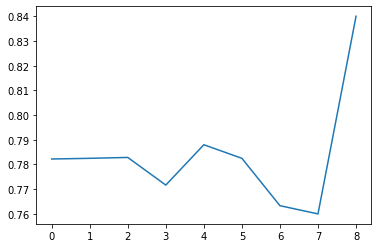

In [8]:
if __name__ == '__main__':
    filename = './kNN_Dating/datingTestSet.txt'
    featureMat, classLabelVector = file2matrix(filename)
    normDataset, ranges, minVals = autoNorm(featureMat)
    np.shape(normDataset)
    acc = []
    for i in np.arange(0.1,1,0.1):
        acc.append(datingClassTest(normDataset, classLabelVector, test_size=i))
    print(acc)
    plt.plot(acc)

## 【手写体数字识别】

## 实验步骤：【手写体数字识别】- 概述

本实验要求构造kNN分类器，实现对手写体数字0到9的识别。

### 数据介绍
数据集目录下有两个子目录：trainingDigits和testDigits  

* trainingDigits为训练数据集的文件，文件数量为1935；
* testDigits为测试数据集的文件，文件数量为947。

每个文件的命名格式都为“真实数字_编号.txt”。为了简便处理，实验中，用txt文本文件表示图片。原图片中像素值为黑色（0,0,0）的像素点在txt中对应的用0表示，像素值为白色（255,255,255）的像素点用1表示。所以，只需要处理这些文本文件即可，不用再去解析图片格式。每个txt文件中，数据共有32行和32列，这是由于原图片的大小为32X32。

## 实验步骤：【手写体数字识别】- 加载手写字训练集数据

由于kNN算法中，每个点都是用向量表示的。手写体数字数据为32X32的二维数据格式，首先需要将其转换为一维数组，即表示成一个向量。函数img2vector用于将表示32X32的二维数组的txt文件转换为一维数组，该函数传入参数文件名，返回转换后的一维数组。函数loadTrainData用于加载全部训练数据。

In [9]:
def img2vector(fileName):
    """
    函数说明：将手写体数字文本转化为一维数组
    parameters:
        fileName - 手写体数字文本文件路径
    return:
        returnVect - 1x1024向量
    """
    dataMat = pd.read_table(fileName, header = None)
    m, n = np.shape(dataMat)
    data = []
    for i in range(m):
        for j in range(len(dataMat[0][i])):
            data.append(int(dataMat[0][i][j]))
    returnVect = np.array(data).reshape(1,-1)
    return returnVect


def loadTrainData(path):
    """
    函数说明：加载目录下所有手写体数字文本文件
    parameters:
        path - 手写体数字文本文件路径
    return:
        hwMat - 训练集数据
        hwLabels - 训练集标签
    """
    hwLabels = []
    hwMat = np.empty(shape=[1, 1024])
    files = os.listdir(path)
    for file in files:
        num = int(file.split('_')[0])
        hwLabels.append(num)
        hwMat = np.concatenate((hwMat, img2vector(path+file)), axis=0)
    hwLabels = np.array(hwLabels).reshape(-1, 1)
    hwMat = hwMat[1:,:]
    return hwMat, hwLabels

## 实验步骤：【手写体数字识别】- 使用测试数据集验证分类算法 

验证kNN手写体识别算法的准确性。测试使用的数据集位于目录testDigits下。测试的流程为：依次读取testDigits目录下的每个文件，根据文件中的数据，重用分类函数kNNClassify确定其类别，并和其真实分类进行对比，如果一致，表示分类正确，如果不一致，表示分类错误。统计错误的数量，计算错误率，错误率为分类出错的数量除以测试集中测试数据总量。编写handwritingClassTest函数测试基于kNN算法实现的手写字识别系统准确性。（输出每个测试样本的预测类别及测试集的错误率，k取3）

In [10]:
def handwritingClassTest():
    """
    函数说明：测试kNN手写体识别算法
    
    """
    train_path = './kNN_hand_writing/trainingDigits/'
    test_path = './kNN_hand_writing/testDigits/'
    
    X_train, y_train = loadTrainData(train_path)
    X_test, y_test = loadTrainData(test_path)
    corCount = 0.0
    errCount = 0.0
    k = 4
    m, n = X_test.shape
    y_test = y_test.flatten()
    for i in range(m):
        y_pred = kNNClassify(X_train[i], X_train, y_train.flatten(), k)
        if y_pred == y_test[i]:
            corCount = corCount + 1
        else:
            errCount = errCount + 1
    accurancy = corCount/(corCount + errCount)
    
    return accurancy

In [13]:
if __name__ == '__main__':
    accurancy = handwritingClassTest()